In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from data_models.basic import Tabular, LOCOData
from models.basic import SVM, LogisticReg, RandForestRegressor
from conformal_prediction.basic import SimpleConformal, SplitConformal
from explainable_models.variable_importance.LOCO import SimpleLOCO, plot_ci, OldConformalLOCO, NewConformalLOCO
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.patches as mpatches
from collections import defaultdict

# Own Variable Importance

So the idea is to implement the following:

1. Estimate the model on the complete training data
2. Find a conformal prediction set (i.e. calibrate) on the calibration data
3. Find an alternative conformal prediction set for the same calibration data but removing the j-th feature
4. Construct both conformal sets (hoping that the alternative conformal prediction is larger)
5. Compute the difference between these two conformal sets

In [3]:
locodata = LOCOData(n=10000)
locodata.X_y_split(y='Y')

In [4]:
random_forest = RandomForestRegressor()
random_forest.fit(locodata.train_data_X, locodata.train_data_y)

RandomForestRegressor()

In [97]:
plot = None
type = 'full'
B = 1000

def IOU(conformal_sets_all, conformal_sets_j): 
    loss = []
    for i in range(len(conformal_sets_all)):
        tmp = (max(0, conformal_sets_all[i][0]-conformal_sets_j[i][0])+
                max(0, conformal_sets_j[i][1]-conformal_sets_all[i][1]))/(max(conformal_sets_all[i][1], conformal_sets_j[i][1])-min(conformal_sets_all[i][0], conformal_sets_j[i][0]))
        loss.append(tmp)
    return sum(loss)

boot_cov = defaultdict(list)
boot_size = defaultdict(list)
boot_IoU = defaultdict(list)

for i in range(B):
    if i % 50 == 0:
        print(i)
    conformal_predictor = SplitConformal(alpha=0.05)
    lambda_all, model_all = conformal_predictor.calibrate(data_X=locodata.calib_data_X, data_y=locodata.calib_data_y, model=RandomForestRegressor())
    pred_all = conformal_predictor.predict(locodata.test_data_X, model=model_all, lambda_conformal=lambda_all)
    cov, size = conformal_predictor.evaluate(pred_all, locodata.test_data_y)
    
    for variable in locodata.calib_data_X.columns:

        conformal_predictor_j = SplitConformal(alpha=0.05)

        if type=='0':
            data_X_j = copy.copy(locodata.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(locodata.test_data_X)
            data_X_test_j[variable] = 0
        if type=='full':
            data_X_j = copy.copy(locodata.calib_data_X)
            data_X_j = data_X_j.loc[:, data_X_j.columns!=variable]
            data_X_test_j = copy.copy(locodata.test_data_X)
            data_X_test_j= data_X_test_j.loc[:, data_X_test_j.columns!=variable]

        lambda_j, model_j = conformal_predictor_j.calibrate(data_X=data_X_j, data_y=locodata.calib_data_y, model=RandomForestRegressor())
        pred_j = conformal_predictor_j.predict(data_X_test_j, model=model_j, lambda_conformal=lambda_j)
        cov_j, size_j = conformal_predictor_j.evaluate(pred_j, locodata.test_data_y)
        IoU = IOU(pred_all, pred_j)
        print('Variable: ', variable)
        print(cov_j)
        print('Size Increase: ', size_j-size)
        print('IoU: ', IoU)
        print('================================')

        boot_cov[variable].extend([cov_j])
        boot_size[variable].extend([size_j-size])
        boot_IoU[variable].extend([IoU])

        if plot:
            y_j = pred_j[:plot]
            y_all = pred_all[:plot]
            x = np.array(range(len(y_j)))

            plt.figure(figsize=(12, 8))
            plt.plot((x+0.07,x+0.07),([i for (i,j) in y_all], [j for (i,j) in y_all]),c='black', solid_capstyle='projecting')
            plt.plot((x-0.07,x-0.07),([i for (i,j) in y_j], [j for (i,j) in y_j]),c='red')

            red_patch = mpatches.Patch(color='black', label='Conformal Set with ALL Features')
            blue_patch = mpatches.Patch(color='red', label='Conformal Set without ONE Feature')

            plt.xlabel('Test Observation (X_{n+1})')
            plt.ylabel('Conformal Set Interval')
            plt.title('Variable Importance for feature \n ' + variable)
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

Overall Coverage and Size:
0.943
4104.251194841703
Variable:  f1
0.943
Size Increase:  358.4361474727939
IoU:  122.78074224142651
Variable:  f2
0.948
Size Increase:  1010.098883501706
IoU:  245.7430577667124
Variable:  f3
0.953
Size Increase:  326.1275585508856
IoU:  106.44583349270349
Variable:  f4
0.937
Size Increase:  -57.615117997896505
IoU:  32.30839094009147
Variable:  f5
0.95
Size Increase:  -19.008559344792047
IoU:  38.21681417153448
Variable:  f6
0.949
Size Increase:  50.710382831315655
IoU:  42.12614083905548
Overall Coverage and Size:
0.945
4067.6784291013923
Variable:  f1
0.943
Size Increase:  293.8179178530959
IoU:  117.20433997066509
Variable:  f2
0.943
Size Increase:  945.2136139504832
IoU:  239.72221230684252
Variable:  f3
0.943
Size Increase:  212.67497000997764
IoU:  93.91400695234108
Variable:  f4
0.934
Size Increase:  -72.24786820560257
IoU:  32.58061979097756
Variable:  f5
0.948
Size Increase:  62.60985305971235
IoU:  46.644465595219046
Variable:  f6
0.949
Size Inc

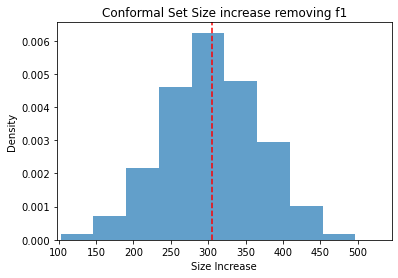

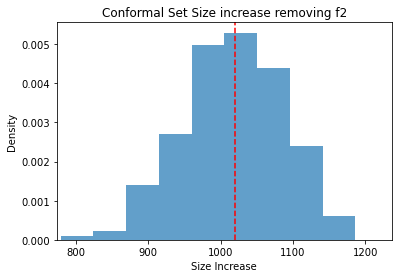

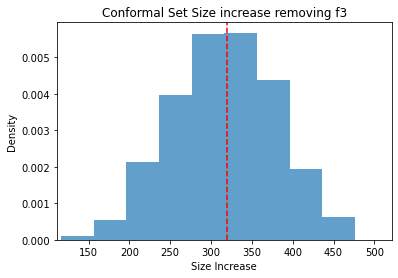

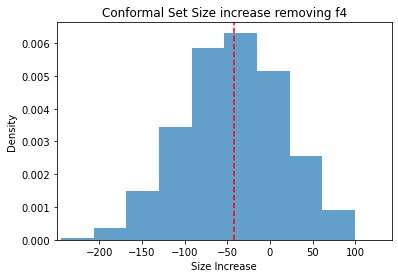

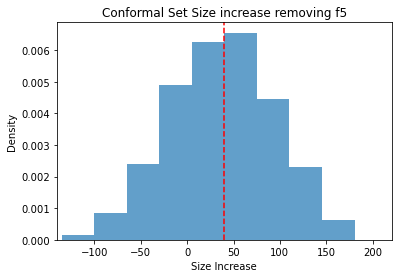

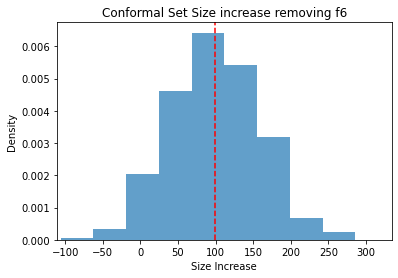

In [101]:
import numpy as np
from matplotlib import pyplot as plt

for variable in locodata.calib_data_X.columns:

    data = boot_size[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/10) # fixed bin size

    plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('Conformal Set Size increase removing ' + variable)
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.savefig('images\LOCO_paper_data\conformal_set_size_increase_'+variable)
    plt.show()

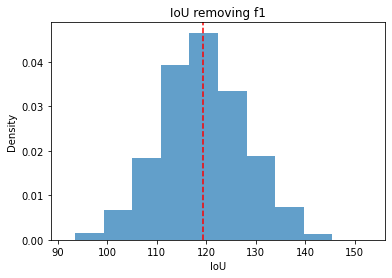

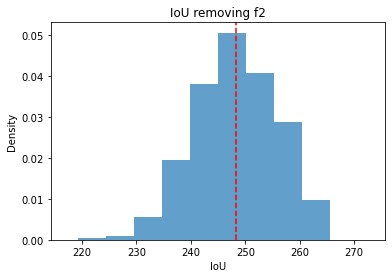

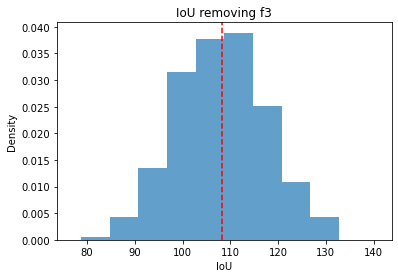

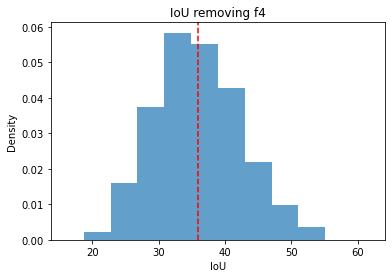

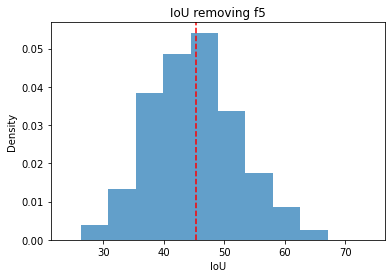

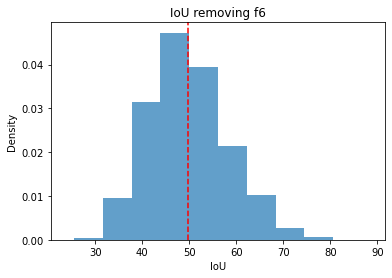

In [102]:
import numpy as np
from matplotlib import pyplot as plt

for variable in locodata.calib_data_X.columns:

    data = boot_IoU[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/10) # fixed bin size

    plt.xlim([min(data)-5, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('IoU removing ' + variable)
    plt.xlabel('IoU')
    plt.ylabel('Density')
    plt.savefig('images\LOCO_paper_data\IoU_'+variable)
    plt.show()

In [ ]:
# Can we improve our coverage by combining both intervals which have high coverage guarantees?
plot = None
type = 'full'
B = 100

overall_cov = 0
overall_size = 0
j_cov = 0
j_size = 0
intersection_cov = 0
intersecion_size = 0

for i in range(B):
    print(i)
    conformal_predictor = SplitConformal(alpha=0.05)
    lambda_all, model_all = conformal_predictor.calibrate(data_X=locodata.calib_data_X, data_y=locodata.calib_data_y, model=RandomForestRegressor())
    pred_all = conformal_predictor.predict(locodata.test_data_X, model=model_all, lambda_conformal=lambda_all)
    cov, size = conformal_predictor.evaluate(pred_all, locodata.test_data_y)
    overall_cov += cov
    overall_size += size

    for variable in locodata.calib_data_X.columns:

        conformal_predictor_j = SplitConformal(alpha=0.05)

        if type=='0':
            data_X_j = copy.copy(locodata.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(locodata.test_data_X)
            data_X_test_j[variable] = 0
        if type=='full':
            data_X_j = copy.copy(locodata.calib_data_X)
            data_X_j = data_X_j.loc[:, data_X_j.columns!=variable]
            data_X_test_j = copy.copy(locodata.test_data_X)
            data_X_test_j= data_X_test_j.loc[:, data_X_test_j.columns!=variable]

        lambda_j, model_j = conformal_predictor_j.calibrate(data_X=data_X_j, data_y=locodata.calib_data_y, model=RandomForestRegressor())
        pred_j = conformal_predictor_j.predict(data_X_test_j, model=model_j, lambda_conformal=lambda_j)
        cov_j, size_j = conformal_predictor_j.evaluate(pred_j, locodata.test_data_y)
        j_cov += cov_j
        j_size += size_j

        # get the min max ranges
        pred_intersect = [(max(i[0], j[0]),min(i[1],j[1])) for i,j in zip(pred_all, pred_j)]
        # check that min is smaller than max
        pred_intersect = [(i,j) for (i,j) in pred_intersect if i < j]
        cov_intersect, size_intersect = conformal_predictor_j.evaluate(pred_intersect, locodata.test_data_y)
        intersection_cov += cov_intersect
        intersecion_size += size_intersect

        if plot:
            y_j = pred_j[:plot]
            y_all = pred_all[:plot]
            x = np.array(range(len(y_j)))

            plt.figure(figsize=(12, 8))
            plt.plot((x+0.07,x+0.07),([i for (i,j) in y_all], [j for (i,j) in y_all]),c='black', solid_capstyle='projecting')
            plt.plot((x-0.07,x-0.07),([i for (i,j) in y_j], [j for (i,j) in y_j]),c='red')

            red_patch = mpatches.Patch(color='black', label='Conformal Set with ALL Features')
            blue_patch = mpatches.Patch(color='red', label='Conformal Set without ONE Feature')

            plt.xlabel('Test Observation (X_{n+1})')
            plt.ylabel('Conformal Set Interval')
            plt.title('Variable Importance for feature \n ' + variable)
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

overall_cov = overall_cov/B
overall_size = overall_size/B
j_cov = j_cov/(6*B)
j_size = j_size/(6*B)
intersection_cov = intersection_cov/(6*B)
intersecion_size = intersecion_size/(6*B)

In [ ]:
# Can we find any relevant trend?
plot = None
type = 'full'
B = 100

upper = defaultdict(list)
lower = defaultdict(list)
y_true_displacement_all = defaultdict(list)
y_true_displacement_j = defaultdict(list)

for i in range(B):
    conformal_predictor = SplitConformal(alpha=0.05)
    lambda_all, model_all = conformal_predictor.calibrate(data_X=locodata.calib_data_X, data_y=locodata.calib_data_y, model=RandomForestRegressor())
    pred_all = conformal_predictor.predict(locodata.test_data_X, model=model_all, lambda_conformal=lambda_all)
    cov, size = conformal_predictor.evaluate(pred_all, locodata.test_data_y)

    for variable in locodata.calib_data_X.columns:

        conformal_predictor_j = SplitConformal(alpha=0.05)

        if type=='0':
            data_X_j = copy.copy(locodata.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(locodata.test_data_X)
            data_X_test_j[variable] = 0
        if type=='full':
            data_X_j = copy.copy(locodata.calib_data_X)
            data_X_j = data_X_j.loc[:, data_X_j.columns!=variable]
            data_X_test_j = copy.copy(locodata.test_data_X)
            data_X_test_j= data_X_test_j.loc[:, data_X_test_j.columns!=variable]

        lambda_j, model_j = conformal_predictor_j.calibrate(data_X=data_X_j, data_y=locodata.calib_data_y, model=RandomForestRegressor())
        pred_j = conformal_predictor_j.predict(data_X_test_j, model=model_j, lambda_conformal=lambda_j)
        cov_j, size_j = conformal_predictor_j.evaluate(pred_j, locodata.test_data_y)

        for i in range(len(pred_all)):
            upper[variable].extend([pred_all[i][1]-pred_j[i][1]])  # If this value is positive it means the pred_j interval is smaller in the upper end
            lower[variable].extend([pred_all[i][0]-pred_j[i][0]])  # If this value is positive it means the pred_j interval is larger in the lower end
            y_true_displacement_all[variable].extend([(pred_all[i][1]+pred_all[i][0])/2-locodata.test_data_y.iloc[i]])  # If this value is positive it means the true value falls in the lower part of the interval
            y_true_displacement_j[variable].extend([(pred_j[i][1]+pred_j[i][0])/2-locodata.test_data_y.iloc[i]])  # If this value is positive it means the true value falls in the lower part of the interval

        if plot:
            y_j = pred_j[:plot]
            y_all = pred_all[:plot]
            x = np.array(range(len(y_j)))

            plt.figure(figsize=(12, 8))
            plt.plot((x+0.07,x+0.07),([i for (i,j) in y_all], [j for (i,j) in y_all]),c='black', solid_capstyle='projecting')
            plt.plot((x-0.07,x-0.07),([i for (i,j) in y_j], [j for (i,j) in y_j]),c='red')
            plt.plot(x, locodata.test_data_y.iloc[:plot].tolist(), 'go')

            red_patch = mpatches.Patch(color='black', label='Conformal Set with ALL Features')
            blue_patch = mpatches.Patch(color='red', label='Conformal Set without ONE Feature')

            plt.xlabel('Test Observation (X_{n+1})')
            plt.ylabel('Conformal Set Interval')
            plt.title('Variable Importance for feature \n ' + variable)
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

In [ ]:
for variable in locodata.calib_data_X.columns:

    plt.hist(upper[variable], density=True)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Upper difference ' + variable)
    plt.savefig(r'images\LOCO_paper_data\upper_'+variable+'.png')

In [ ]:
for variable in locodata.calib_data_X.columns:

    plt.hist(lower[variable], density=True)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Lower difference ' + variable)
    plt.savefig(r'images\LOCO_paper_data\lower_'+variable+'.png')
    plt.show()

In [ ]:
plt.hist(y_true_displacement_all[variable], density=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('True Prediction difference')
plt.savefig(r'images\LOCO_paper_data\true_diff.png')
plt.show()

In [ ]:
for variable in locodata.calib_data_X.columns:

    plt.hist(y_true_displacement_j[variable], density=True)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('True Prediction difference ' + variable)
    plt.savefig(r'images\LOCO_paper_data\j_true_diff_'+variable+'.png')
    plt.show()

In [ ]:
# Let's try to generate perturbed datasets over which we have complete control, with very few differences and see if that way we can find some kind of trend

def IOU(conformal_sets_all, conformal_sets_j): 
    loss = []
    for i in range(len(conformal_sets_all)):
        tmp = (max(0, conformal_sets_all[i][0]-conformal_sets_j[i][0])+
                max(0, conformal_sets_j[i][1]-conformal_sets_all[i][1]))/(max(conformal_sets_all[i][1], conformal_sets_j[i][1])-min(conformal_sets_all[i][0], conformal_sets_j[i][0]))
        loss.append(tmp)
    return sum(loss)

locodata = LOCOData(n=10000, interval=None)
locodata.X_y_split(y='Y')

# bins = [[-1, -0.9], [-0.9, -0.8], [-0.8, -0.7], [-0.7, -0.6], [-0.6, -0.5], [-0.5, -0.4], [-0.4, -0.3], [-0.3, -0.2], [-0.2, -0.1], [-0.1, 0],
#         [0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1]]
bins = [[-1, -0.9], [-0.1, 0], [0.9, 1]]

intervals = []
for i in bins:
    intervals.append([i, [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1]])

plot = None
type = 'full'
B = 100

for interval in intervals:
    print(interval)
    locodata_biased = LOCOData(n=10000, interval=interval)
    locodata_biased.X_y_split(y='Y')

    upper = defaultdict(list)
    lower = defaultdict(list)
    y_true_displacement_all = defaultdict(list)
    y_true_displacement_j = defaultdict(list)
    boot_cov = defaultdict(list)
    boot_size = defaultdict(list)
    boot_IoU = defaultdict(list)

    for i in range(B):

        conformal_predictor = SplitConformal(alpha=0.05)
        lambda_all, model_all = conformal_predictor.calibrate(data_X=locodata.calib_data_X, data_y=locodata.calib_data_y, model=RandomForestRegressor())
        pred_all = conformal_predictor.predict(locodata_biased.test_data_X, model=model_all, lambda_conformal=lambda_all)
        cov, size = conformal_predictor.evaluate(pred_all, locodata_biased.test_data_y)
        
        for variable in locodata.calib_data_X.columns:

            conformal_predictor_j = SplitConformal(alpha=0.05)

            if type=='0':
                data_X_j = copy.copy(locodata.calib_data_X)
                data_X_j[variable] = 0
                data_X_test_j = copy.copy(locodata_biased.test_data_X)
                data_X_test_j[variable] = 0
            if type=='full':
                data_X_j = copy.copy(locodata.calib_data_X)
                data_X_j = data_X_j.loc[:, data_X_j.columns!=variable]
                data_X_test_j = copy.copy(locodata_biased.test_data_X)
                data_X_test_j= data_X_test_j.loc[:, data_X_test_j.columns!=variable]

            lambda_j, model_j = conformal_predictor_j.calibrate(data_X=data_X_j, data_y=locodata.calib_data_y, model=RandomForestRegressor())
            pred_j = conformal_predictor_j.predict(data_X_test_j, model=model_j, lambda_conformal=lambda_j)
            cov_j, size_j = conformal_predictor_j.evaluate(pred_j, locodata_biased.test_data_y)
            IoU = IOU(pred_all, pred_j)

            boot_cov[variable].extend([cov_j])
            boot_size[variable].extend([size_j-size])
            boot_IoU[variable].extend([IoU])

            for i in range(len(pred_all)):
                upper[variable].extend([pred_all[i][1]-pred_j[i][1]])  # If this value is positive it means the pred_j interval is smaller in the upper end
                lower[variable].extend([pred_all[i][0]-pred_j[i][0]])  # If this value is positive it means the pred_j interval is larger in the lower end
                y_true_displacement_all[variable].extend([(pred_all[i][1]+pred_all[i][0])/2-locodata.test_data_y.iloc[i]])  # If this value is positive it means the true value falls in the lower part of the interval
                y_true_displacement_j[variable].extend([(pred_j[i][1]+pred_j[i][0])/2-locodata.test_data_y.iloc[i]])  # If this value is positive it means the true value falls in the lower part of the interval

            if plot:
                y_j = pred_j[:plot]
                y_all = pred_all[:plot]
                x = np.array(range(len(y_j)))

                plt.figure(figsize=(12, 8))
                plt.plot((x+0.07,x+0.07),([i for (i,j) in y_all], [j for (i,j) in y_all]),c='black', solid_capstyle='projecting')
                plt.plot((x-0.07,x-0.07),([i for (i,j) in y_j], [j for (i,j) in y_j]),c='red')
                plt.plot(x, locodata.test_data_y.iloc[:plot].tolist(), 'go')

                red_patch = mpatches.Patch(color='black', label='Conformal Set with ALL Features')
                blue_patch = mpatches.Patch(color='red', label='Conformal Set without ONE Feature')

                plt.xlabel('Test Observation (X_{n+1})')
                plt.ylabel('Conformal Set Interval')
                plt.title('Variable Importance for feature \n ' + variable)
                plt.legend(handles=[red_patch, blue_patch])
                plt.show()

    for variable in locodata.calib_data_X.columns:

        data = boot_size[variable] 

        # fixed bin size
        bins = np.arange(min(data), max(data), (max(data)-min(data))/10) # fixed bin size

        plt.xlim([min(data)-5, max(data)+5])

        plt.hist(data, bins=bins, alpha=0.7, density=True)
        plt.axvline(x=np.mean(data), color='red', linestyle='--')
        plt.title('Conformal Set Size increase removing ' + variable + '\n' + str(interval))
        plt.xlabel('Size Increase')
        plt.ylabel('Density')
        plt.show()

    for variable in locodata.calib_data_X.columns:

        data = boot_IoU[variable] 

        # fixed bin size
        bins = np.arange(min(data), max(data), (max(data)-min(data))/10) # fixed bin size

        plt.xlim([min(data)-5, max(data)+5])

        plt.hist(data, bins=bins, alpha=0.7, density=True)
        plt.axvline(x=np.mean(data), color='red', linestyle='--')
        plt.title('IoU removing ' + variable + '\n' + str(interval))
        plt.xlabel('IoU')
        plt.ylabel('Density')
        plt.show()

    for variable in locodata.calib_data_X.columns:

        plt.hist(upper[variable], density=True)
        plt.axvline(x=0, color='red', linestyle='--')
        plt.title('Upper difference ' + variable + '\n' + str(interval))
        plt.show()

    for variable in locodata.calib_data_X.columns:

        plt.hist(lower[variable], density=True)
        plt.axvline(x=0, color='red', linestyle='--')
        plt.title('Lower difference ' + variable + '\n' + str(interval))
        plt.show()

    plt.hist(y_true_displacement_all[variable], density=True)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('True Prediction difference' + '\n' + str(interval))
    plt.show()

    for variable in locodata.calib_data_X.columns:

        plt.hist(y_true_displacement_j[variable], density=True)
        plt.axvline(x=0, color='red', linestyle='--')
        plt.title('True Prediction difference ' + variable + '\n' + str(interval))
        plt.show()
    
    print('=====================================')
    print('=====================================')
    print('=====================================')